In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd

In [2]:
from BlockDefinitions import *
from Functions import *

In [3]:
n_wires = 12
dev = qml.device('lightning.qubit', wires = n_wires, shots=20000)

In [4]:
res = [0, 5, 2, 3, 4]
proj = [1, 6, 7, 9, 8, 10, 11]
    
def circ():
    circA(wires=[0,1,2,3,4])
    circB(wires=[5,1,6,7,8])
    circC(wires=[2,6,9,10])
    circD(wires=[3,7,9,11])
    circE(wires=[4,8,10,11])

In [5]:
@qml.qnode(dev, diff_method='parameter-shift')
def cost_circ(initial_layer_weights, weights):
    circ()
    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=res)
    return qml.probs(wires=range(n_wires))

In [6]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights), n_wires, res)

In [7]:
def foo(params):
    opt = qml.AdamOptimizer(stepsize=0.1)

    max_iterations = 500
    conv_tol = 1e-06

    cost = 0

    costs=[]
    paramses = []
    paramses.append(params)

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_fn, *params)
        conv = np.abs(cost - prev_cost)
        cost=prev_cost
        costs.append(cost)
        paramses.append(params)
        
        # if n % 1 == 0:
        #     print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

        if conv <= conv_tol:
            break
        
    return costs, paramses

In [8]:
shape = qml.SimplifiedTwoDesign.shape(n_layers=3, n_wires=5)

In [9]:
initial_params_list = [[np.random.rand(*shape[0])*2*np.pi, np.random.rand(*shape[1])*2*np.pi] for i in range(10)]

In [10]:
costses=[]
params_last = []
with Pool() as pool:
    result = pool.imap_unordered(foo, initial_params_list)
    for costs, params in result:
        costses.append(costs)
        params_last.append(params)

In [11]:
# pd.DataFrame(costses).to_csv('cost_history_pentagram.csv', index=False)

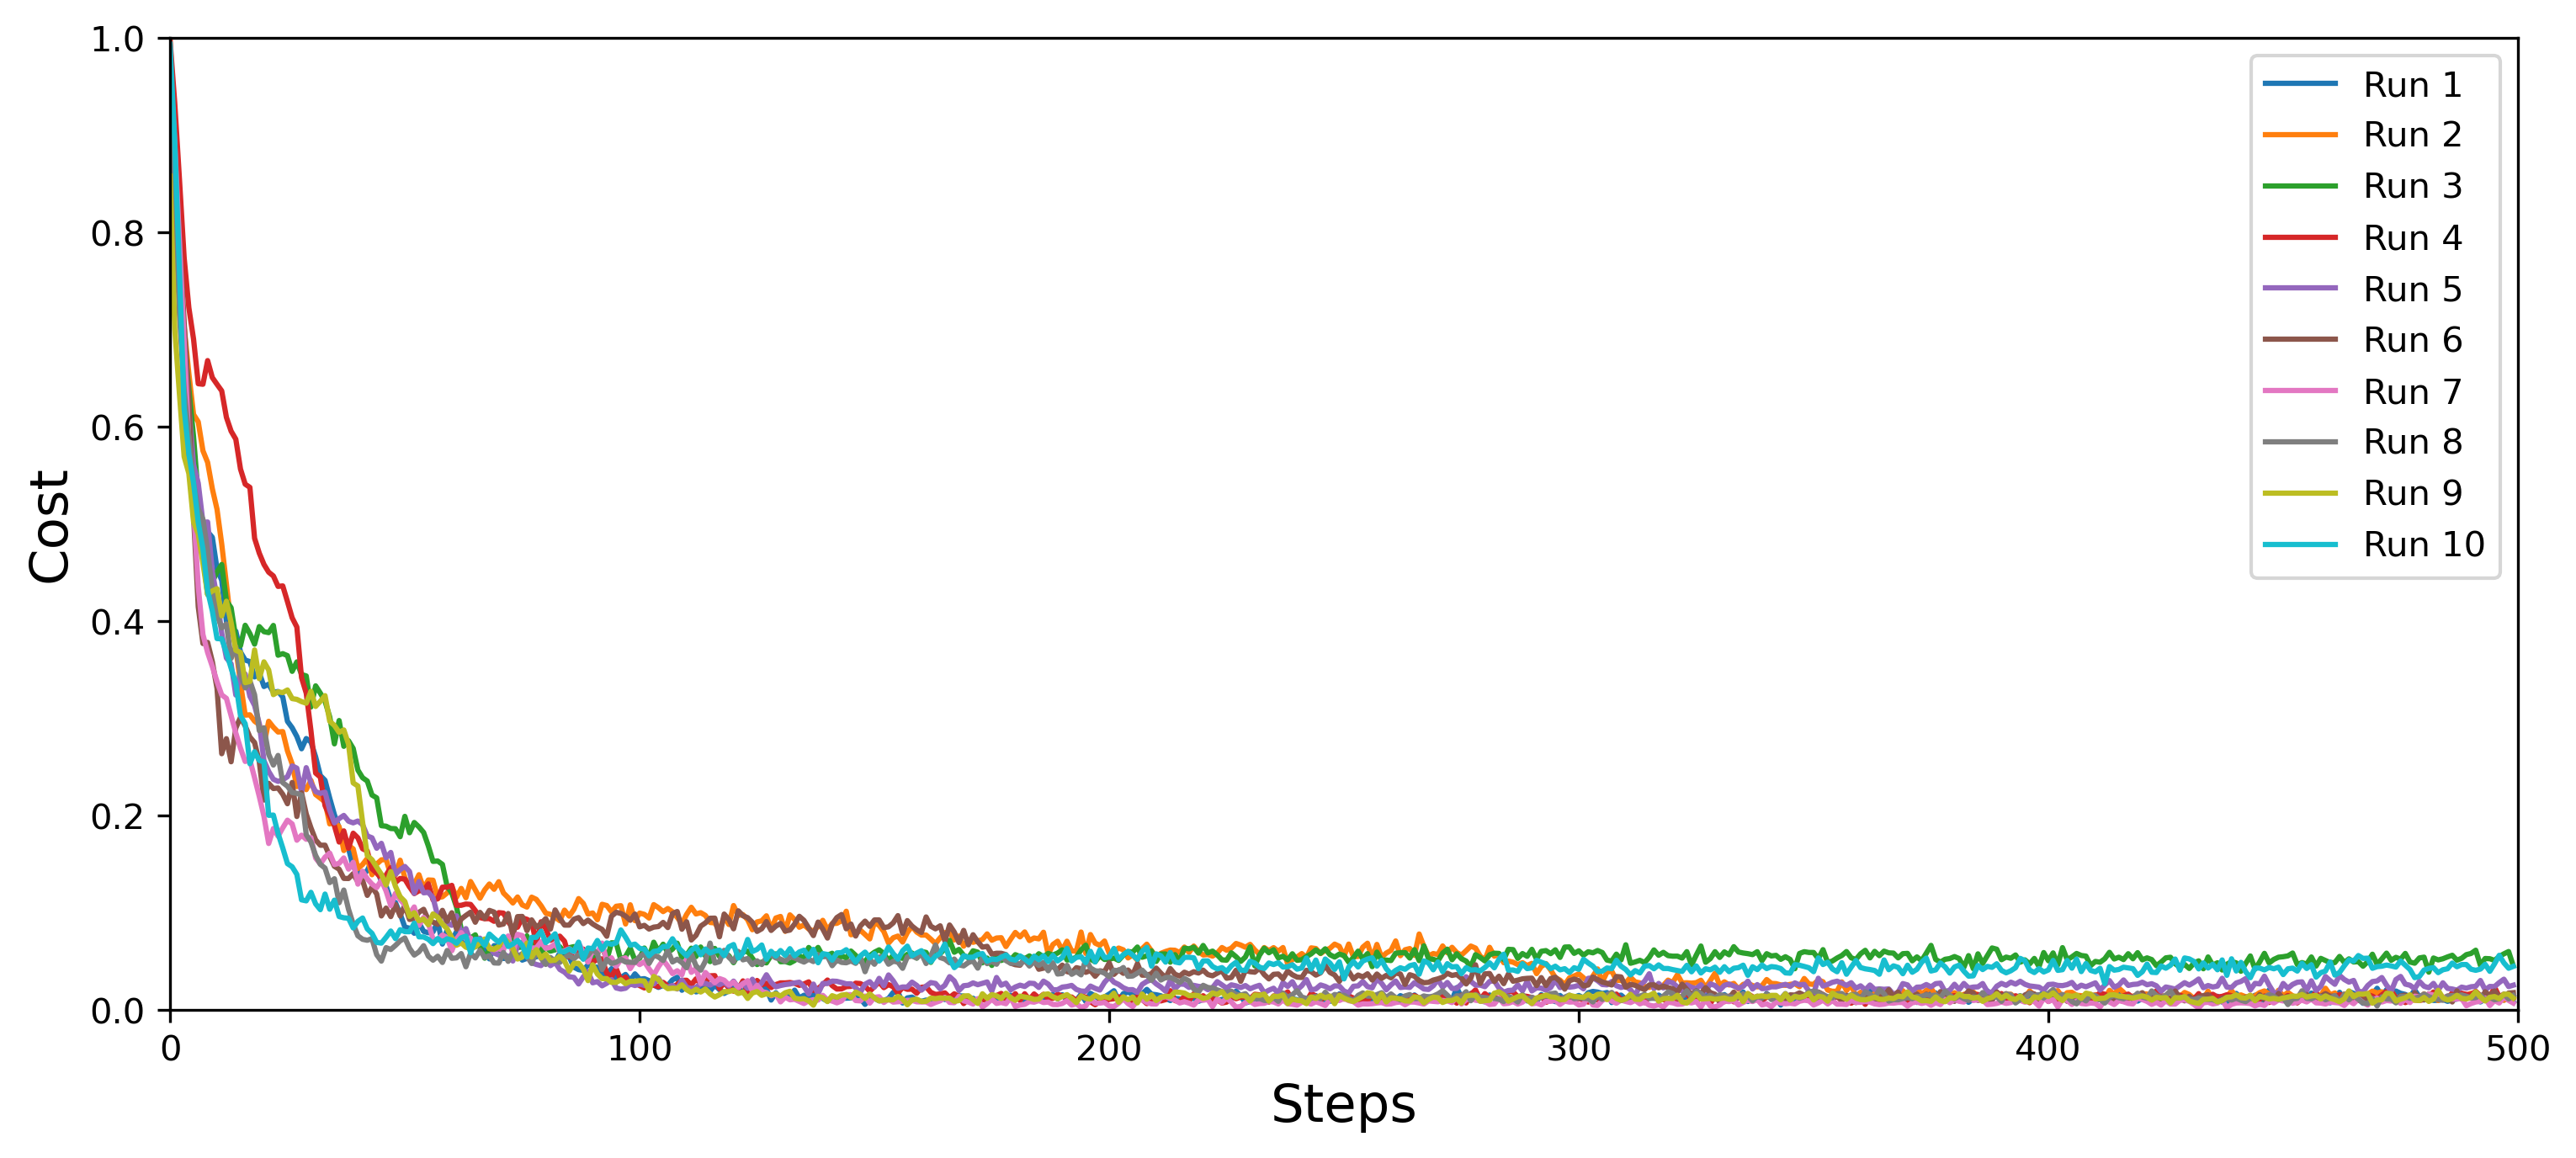

In [91]:
plt.figure(figsize=(12,5), dpi=300)
for i,costs in enumerate(pd.read_csv('cost_history_pentagram.csv').to_numpy()):
    plt.plot(costs, label=f'Run {i+1}')
plt.xlabel('Steps', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.ylim(0,1)
plt.xlim(0,500)
plt.legend()
# plt.savefig('Pentagram2.png')

In [15]:
# for i, params in enumerate(params_last):
#     save_params(params[-1], 'params_last_pentagram/'+str(i)+'.csv')

In [16]:
def fidelity(params):
    @qml.qnode(qml.device('lightning.qubit', wires=5))
    def pentagram(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1,2,3,4])
        return qml.state()

    pentagram_exact = 1/np.sqrt(14)*np.array([3/2,0,0,3/2,0,0,0,0,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,1,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,-1,3/2,0,0,-1/2,0,-1,1,0])

    return np.abs(np.dot(pentagram(params), pentagram_exact))


In [89]:
fidelities_last = []
for i in range(10):
    params = load_params('params_last_pentagram/'+str(i)+'.csv')
    fidelities_last.append(fidelity(params))

print('Fidelities:')
print('Mean: ',np.mean(fidelities_last), 'std: ',np.std(fidelities_last))

Fidelities:
Mean:  0.9896773145373311 std:  0.007273695173466686


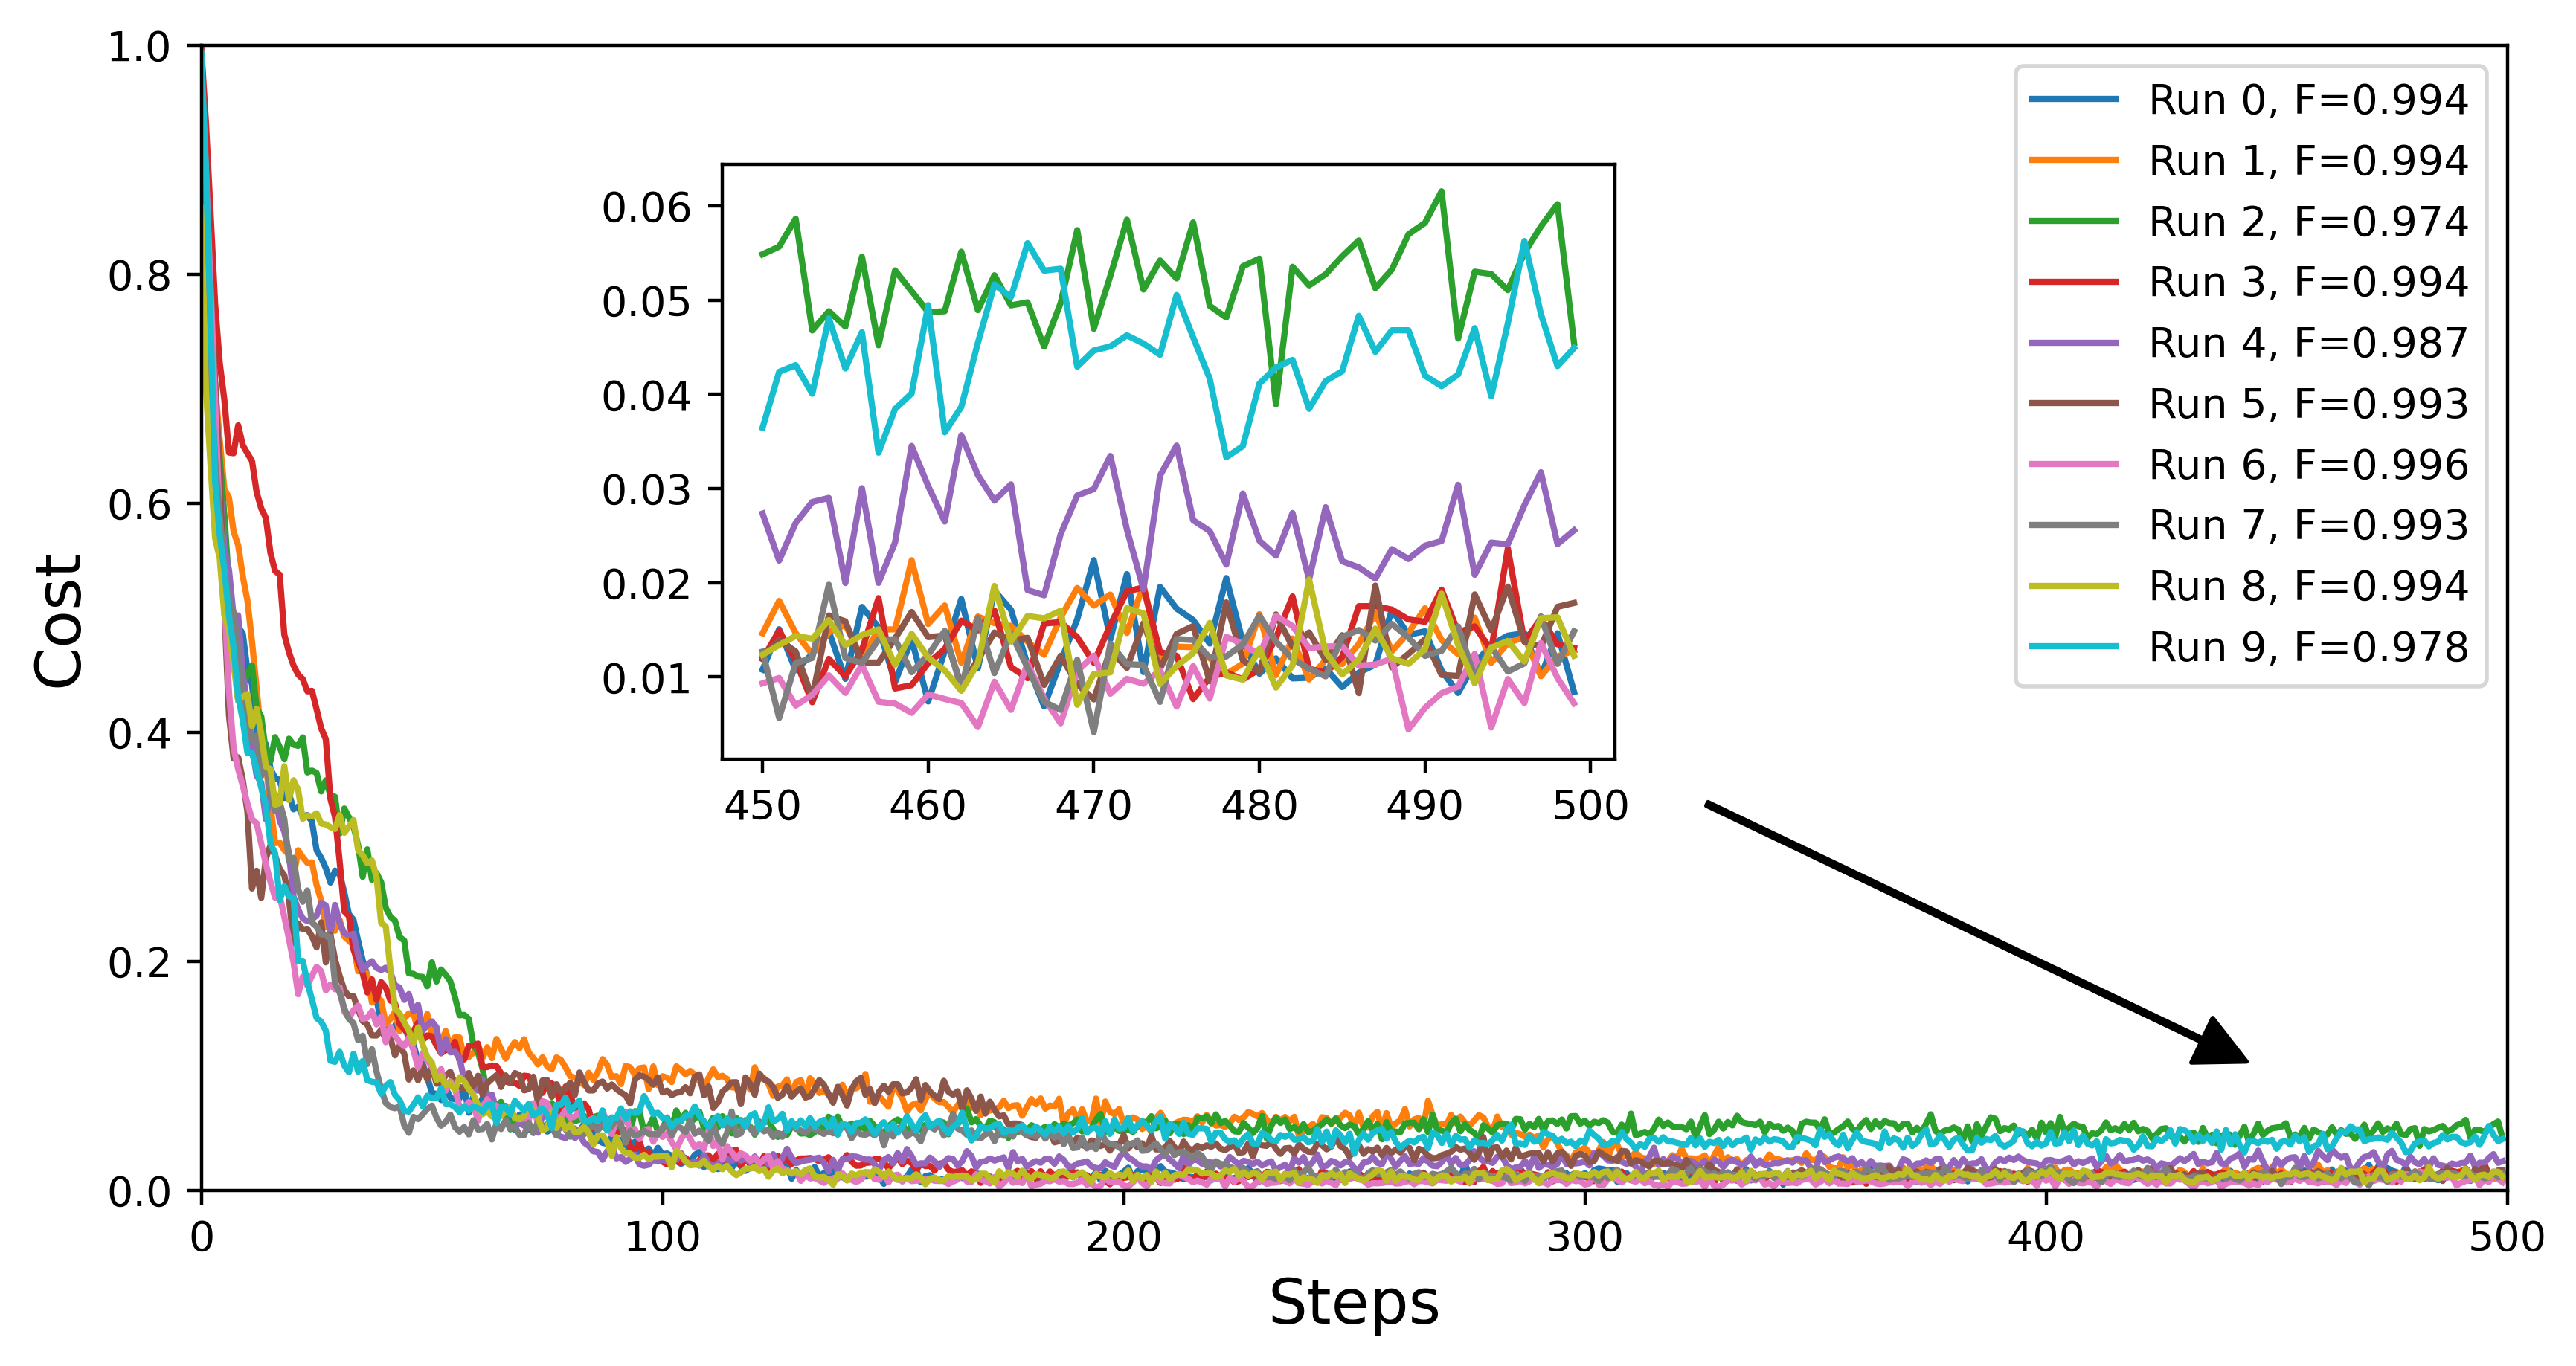

In [88]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,5)
fig.set_dpi(400)
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.3, 0.4, 0.3, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
for i,costs in enumerate(pd.read_csv('cost_history_pentagram.csv').to_numpy()):
    ax1.plot(costs, label=f'Run {i}, F={fidelities_last[i]:.3f}')
for i,costs in enumerate(pd.read_csv('cost_history_pentagram.csv').to_numpy()):
    ax2.plot(range(450,500),costs[450:], label=f'Run {i+1}')
ax1.annotate('',[450,0.1],[320,0.35],arrowprops=dict(facecolor='black', shrink=0.05, width=1))
ax1.set_xlabel('Steps', fontsize=15)
ax1.set_ylabel('Cost', fontsize=15)
ax1.set_ylim(0,1)
ax1.set_xlim(0,500)
ax1.legend()
fig.savefig('Pentagram.png')